# Planet: Understanding the Amazon deforestation from Space challenge

Special thanks to the kernel contributors of this challenge who helped me find a starting point for this notebook.

**If you found this notebook useful some upvotes would be greatly appreciated! :) **

Start by adding the helper files to the python path

In [1]:
import sys

sys.path.append('../src')
sys.path.append('../tests')

## Import required modules

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from keras_tqdm import TQDMNotebookCallback

import data_helper
from keras_helper import AmazonKerasClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


Print tensorflow version for reuse (the Keras module is used directly from the tensorflow framework)

In [3]:
tf.__version__

'1.1.0'

## Inspect image labels
Lets take a look at what the training set looks like

In [4]:
train_jpeg_dir, test_jpeg_dir, train_csv_file = data_helper.get_jpeg_data_files_paths()
labels_df = pd.read_csv(train_csv_file)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Each image can be tagged with multiple tags, lets list all uniques tags

In [5]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'clear', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'habitation', 'water', 'slash_burn', 'blooming', 'haze', 'cloudy', 'blow_down', 'primary', 'road', 'agriculture', 'selective_logging', 'partly_cloudy', 'cultivation'}


### Repartition of each labels

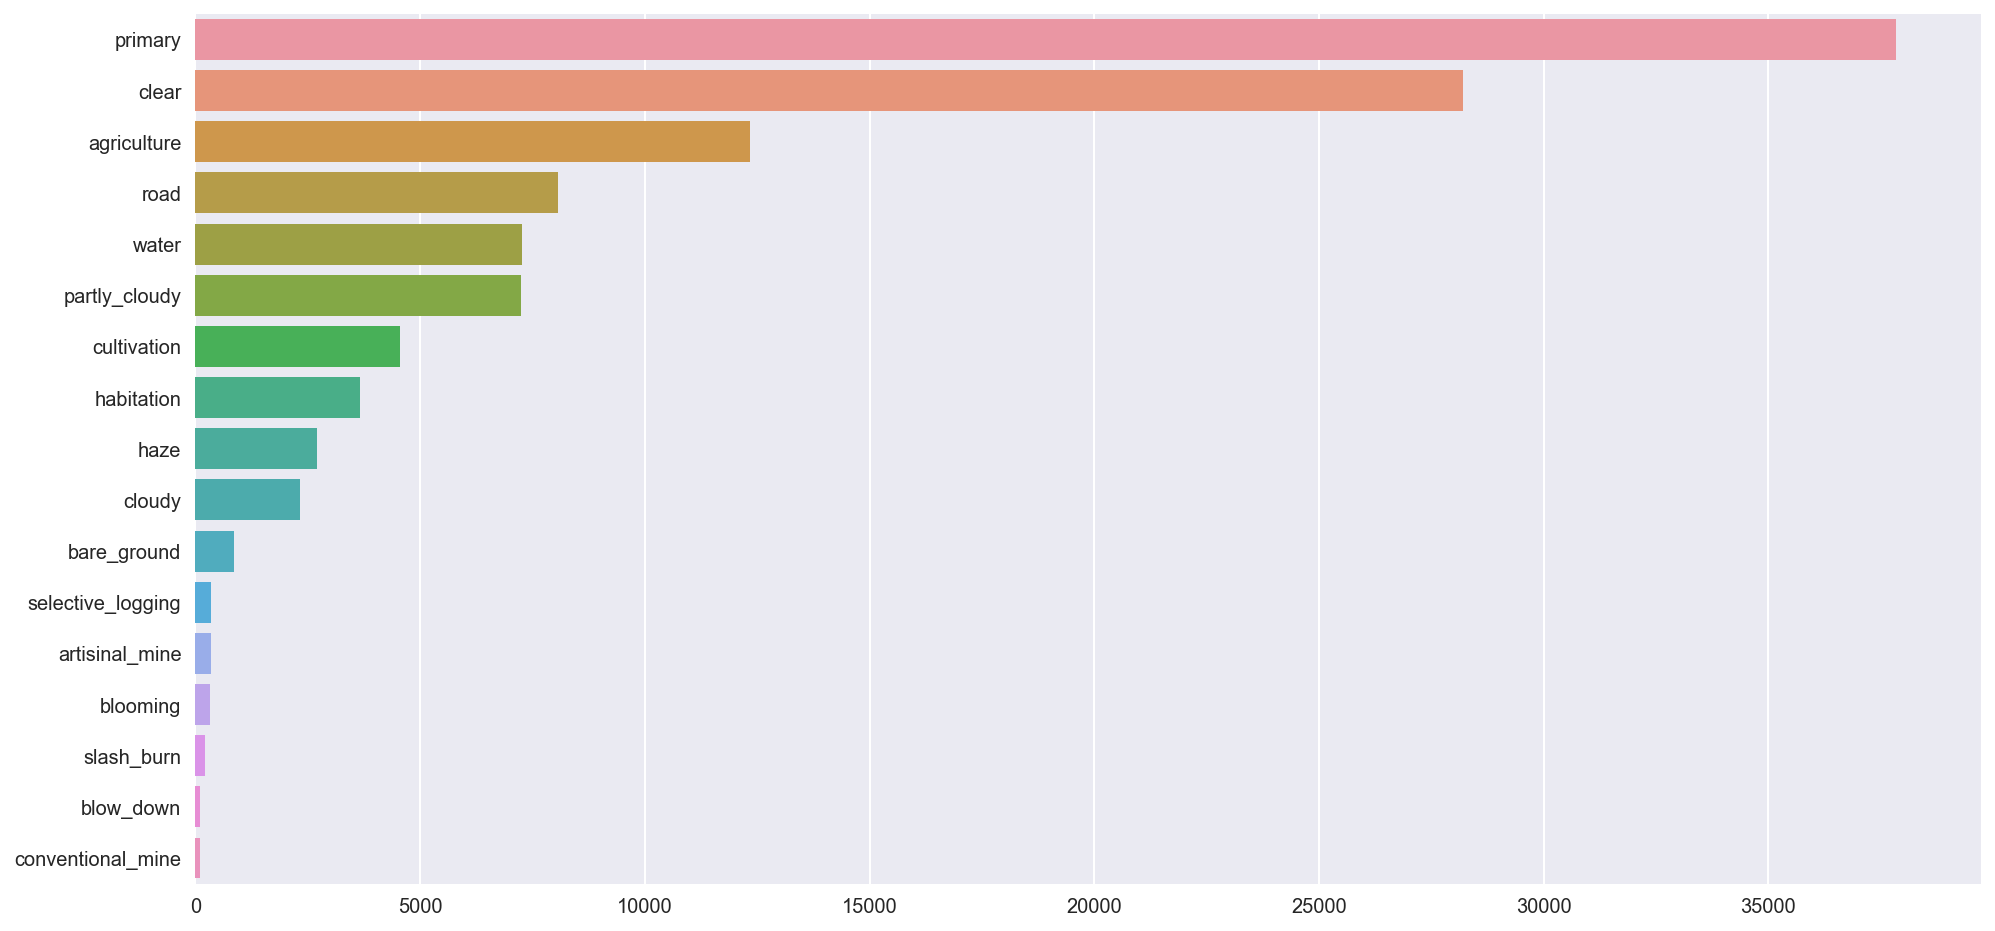

In [6]:
# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

## Images
Finally lets visualize some chip images to know what we are dealing with.
Lets vizualise 1 chip for the 17 images to get a sense of their differences.

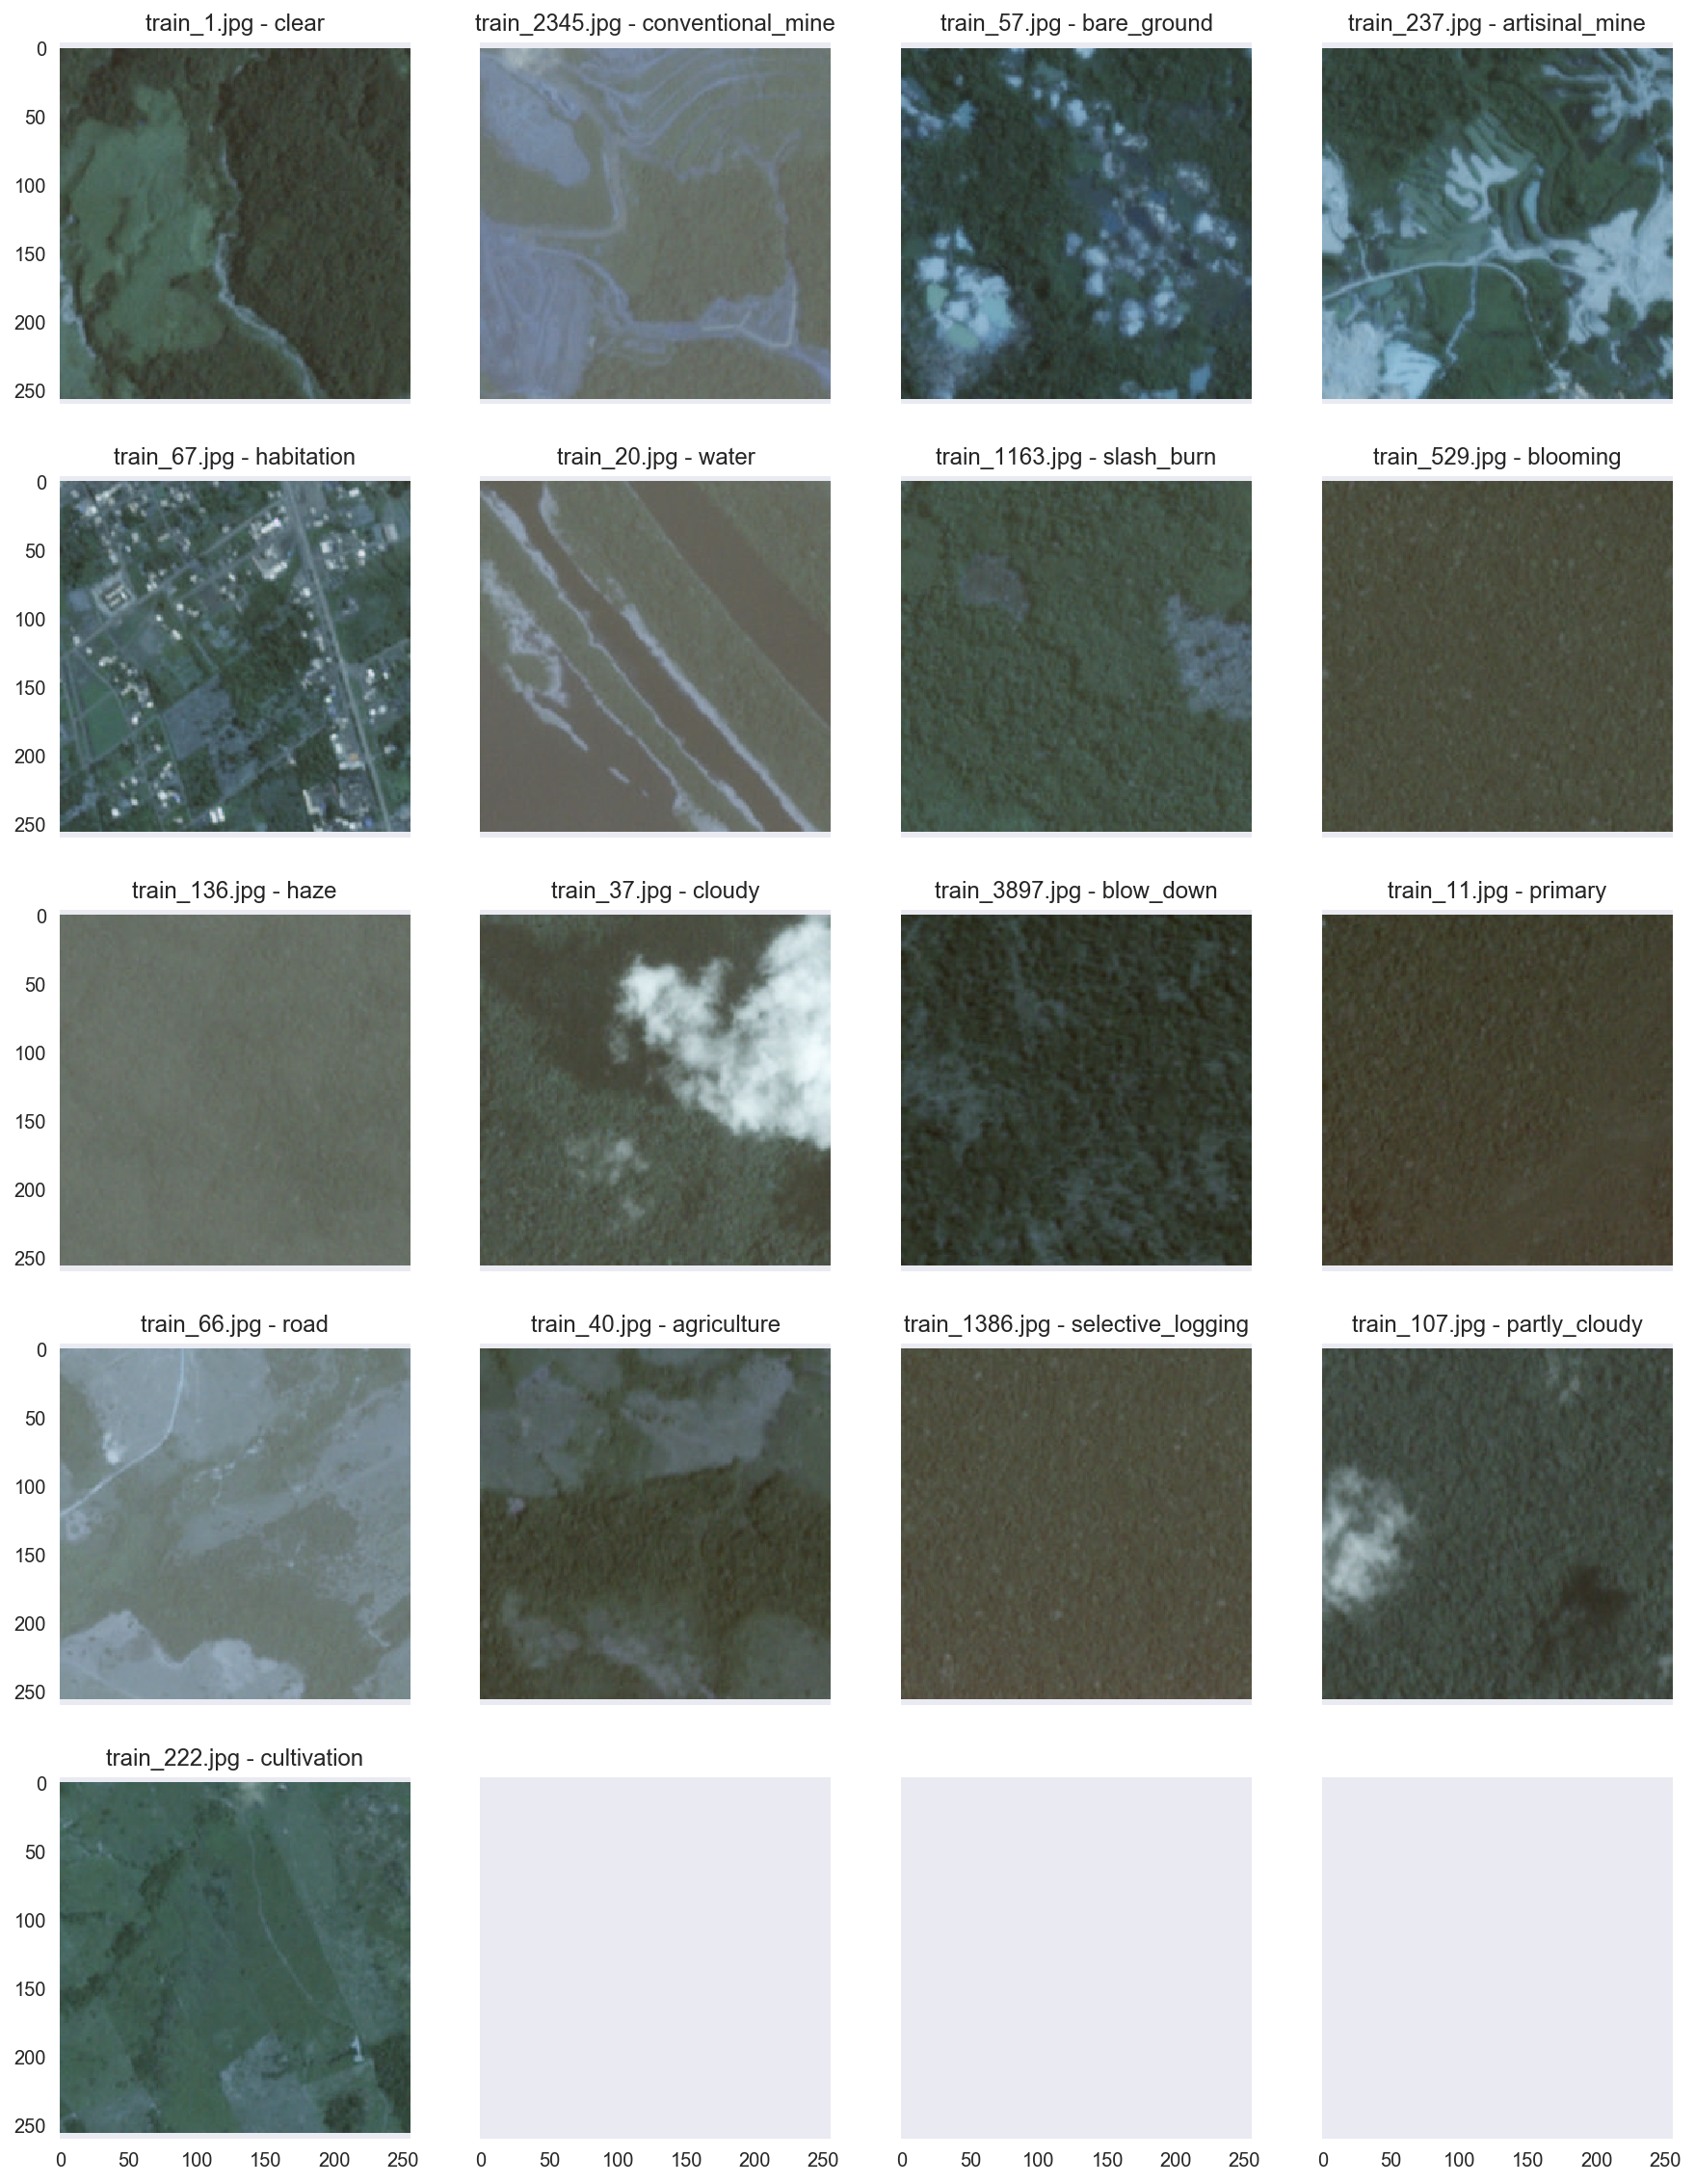

In [7]:
images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = cv2.imread(train_jpeg_dir + '/' + image_name, cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

# Define hyperparameters
First we define our hyperparamters of our neural network

In [8]:
img_resize = (64, 64) # The resize size of each image
epochs = 20
batch_size = 512

# Data preprocessing
Preprocess the data in order to fit it into the Keras model

In [9]:
x_train, x_test, y_train, y_map, x_test_filename = data_helper.preprocess_data(train_jpeg_dir, test_jpeg_dir, 
                                                                               train_csv_file, img_resize)

Transforming train data to matrices...


100%|██████████| 40479/40479 [00:30<00:00, 1306.71it/s]


Transforming test data to matrices...


100%|██████████| 40669/40669 [00:30<00:00, 1322.04it/s]


Done.


Lets take a look at our `y_map` and the shape of our train/test sets

In [10]:
print("x_train shape: {}".format(x_train.shape))
print("x_test  shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
y_map

x_train shape: (40479, 64, 64, 3)
x_test  shape: (40479, 64, 64, 3)
y_train shape: (40479, 17)


{0: 'agriculture',
 1: 'artisinal_mine',
 2: 'bare_ground',
 3: 'blooming',
 4: 'blow_down',
 5: 'clear',
 6: 'cloudy',
 7: 'conventional_mine',
 8: 'cultivation',
 9: 'habitation',
 10: 'haze',
 11: 'partly_cloudy',
 12: 'primary',
 13: 'road',
 14: 'selective_logging',
 15: 'slash_burn',
 16: 'water'}

## Create the neural network definition

In [11]:
classifier = AmazonKerasClassifier()
classifier.add_conv_layer(img_resize)
classifier.add_flatten_layer()
classifier.add_ann_layer(len(y_map))
train_losses, val_losses, fbeta_score = classifier.train_model(x_train, y_train, epochs, batch_size, train_callbacks=[TQDMNotebookCallback()])

Now lets check that we do not overfit by plotting the losses of the train and validation sets

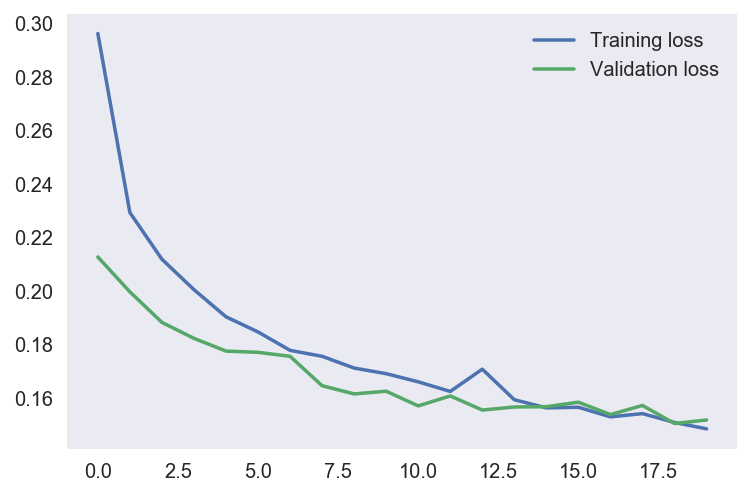

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend();

Lets look at our fbeta_score

In [13]:
fbeta_score

0.86252383056785331

Not that bad...

In [14]:
predictions = classifier.predict(x_test, y_map)
predictions[:10]

[['cloudy'],
 ['cloudy', 'water'],
 ['clear', 'habitation', 'primary', 'road'],
 ['road'],
 ['artisinal_mine', 'clear', 'primary', 'road', 'water'],
 ['primary', 'road', 'water'],
 ['cloudy'],
 ['primary', 'road'],
 [],
 ['primary', 'road']]

Finally lets assemble and visualize our prediction for the test dataset

In [15]:
tags_list = [None] * len(predictions)
for i, tags in enumerate(predictions):
    tags_list[i] = ' '.join(map(str, tags))
   
final_data = [[filename.split(".")[0], tags] for filename, tags in zip(x_test_filename, tags_list)]

In [16]:
final_df = pd.DataFrame(final_data, columns=['image_name', 'tags'])
final_df.head()

,image_name,tags
0,test_7329,cloudy
1,test_10598,cloudy water
2,test_3192,clear habitation primary road
3,test_23467,road
4,test_6967,artisinal_mine clear primary road water


And save it to a submission file

In [17]:
final_df.to_csv('../submission_file.csv', index=False)

That's it, we're done!